In [47]:

import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from PIL import Image
import yaml


def loaddata(show_im=True):
    psf = Image.open(psfname)
    psf = np.array(psf, dtype='float32')
    data = Image.open(imgname)
    data = np.array(data, dtype='float32')
    
    """In the picamera, there is a non-trivial background 
    (even in the dark) that must be subtracted"""
    bg = np.mean(psf[5:15,5:15]) 
    psf -= bg
    data -= bg
    
    """Resize to a more manageable size to do reconstruction on. 
    Because resizing is downsampling, it is subject to aliasing 
    (artifacts produced by the periodic nature of sampling). Demosaicing is an attempt
    to account for/reduce the aliasing caused. In this application, we do the simplest
    possible demosaicing algorithm: smoothing/blurring the image with a box filter"""
    
    def resize(img, factor):
        num = int(-np.log2(factor))
        for i in range(num):
            img = 0.25*(img[::2,::2,...]+img[1::2,::2,...]+img[::2,1::2,...]+img[1::2,1::2,...])
        return img    
    
    psf = resize(psf, f)
    data = resize(data, f)
    
    
    """ nmormalizing copy from shreyas"""
    psf /= np.linalg.norm(psf.ravel())
    data /= np.linalg.norm(data.ravel())
    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')
        plt.show()
        fig2 = plt.figure()
        plt.imshow(data, cmap='gray')
        plt.title('Raw data')
        plt.show()
    return psf, data

def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start

    init_shape = h.shape
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    H = fft.fft2(hpad, norm="ortho")
    Hadj = np.conj(H)

    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    
    return H, Hadj, v, utils

def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    return np.real(calcAHerm(Hadj, diff, pad))

def calcA(H, vk, crop):
    Vk = fft.fft2(vk, norm="ortho")
    return crop(fft.ifftshift(fft.ifft2(H*Vk, norm="ortho")))

def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(xpad, norm="ortho")
    return fft.ifftshift(fft.ifft2(Hadj*X, norm="ortho"))


def grad_descent(h, b):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
        
    alpha = np.real(2/(np.max(Hadj * H)))
    iterations = 0
     
    def non_neg(xi):
        xi = np.maximum(xi,0)
        return xi

    # proj = lambda x: x #Do no projection
    proj = non_neg #Enforce nonnegativity at every gradient step. Comment out as needed.


    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v
    
    
    
    #### uncomment for Nesterov momentum update ####   
    #p = 0
    #mu = 0.9
    ################################################
    
    
    
    #### uncomment for FISTA update ################
    tk = 1
    xk = v
    ################################################
        
    for iterations in range(iters):   
        
        # uncomment for regular GD update
        vk = gd_update(vk, parent_var)
        
        # uncomment for Nesterov momentum update 
        #vk, p = nesterov_update(vk, p, mu, parent_var)
        
        # uncomment for FISTA update
        # vk, tk, xk = fista_update(vk, tk, xk, parent_var)

        if iterations % disp_pic == 0:
            print(iterations)
            image = proj(crop(vk))
            # f = plt.figure(1)
            # plt.imshow(image, cmap='gray')
            # plt.title('Reconstruction after iteration {}'.format(iterations))
            # plt.show()
    
    
    return proj(crop(vk)) 
    
def gd_update(vk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    vk = proj(vk)
    
    # return xk    
    return vk    


def nesterov_update(vk, p, mu, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    p_prev = p
    gradient = grad(Hadj, H, vk, b, crop, pad)
    p = mu*p - alpha*gradient
    vk += -mu*p_prev + (1+mu)*p
    vk = proj(vk)
    
    return vk, p

def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    return vk, tk, xk


In [49]:


if __name__ == "__main__":
    ### Reading in params from config file (don't mess with parameter names!)
    params = yaml.full_load(open("gd_config.yml"))
    for k,v in params.items():
        exec(k + "=v")

    psfname = "./tutorial/psf_sample.tif"
    imgname = "./tutorial/rawdata_hand_sample.tif"
        

    f = 0.5 #Downsampling factor (must be decimal, must be 1/2^k where k is positive integer)
    iters = 100 #Number of iterations
    disp_pic = 20 #Number of iterations after which we display intermediate reconstruction
            

    # psf, data = loaddata()


In [44]:
psf = Image.open(psfname)
width, height = psf.size

data = Image.open(imgname)

psf = psf.resize((width//4, height//4))
data = data.resize((width//4, height//4))

psf = np.array(psf, dtype='float32')
data = np.array(data, dtype='float32')

psf /= np.linalg.norm(psf.ravel(), ord=1)
# data /= np.linalg.norm(data.ravel())
    


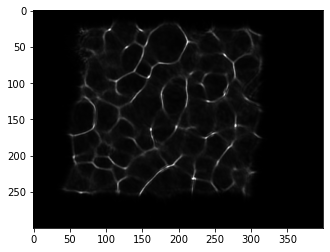

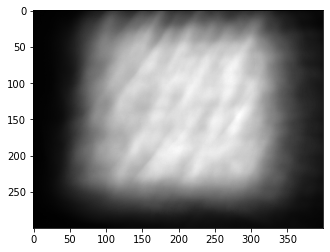

In [45]:
plt.figure()
plt.imshow(psf, cmap='gray')

plt.figure()
plt.imshow(data, cmap='gray')

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500


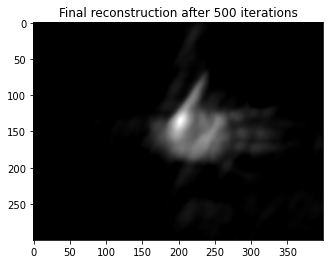

In [51]:

iters = 500

final_im = grad_descent(psf, data)
print(iters)

plt.figure()
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstruction after {} iterations'.format(iters))
plt.show()


In [6]:
# image = Image.fromarray(final_im)
# image = image.convert('RGB')
# image.save('result.jpg')


In [7]:
final_im.max()

702537800.0

In [73]:
psf_rgb = np.load('test_images/sample1_sgm5_psf.npy')
# width, height = psf.size

img_rgb = Image.open('test_images/sample1_sgm5.jpg')
img_rgb = np.array(img_rgb)
img_reconstructed = np.zeros_like(img_rgb)


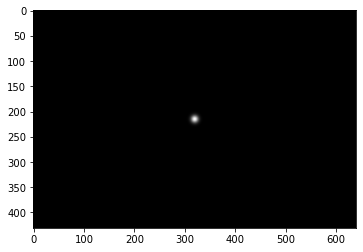

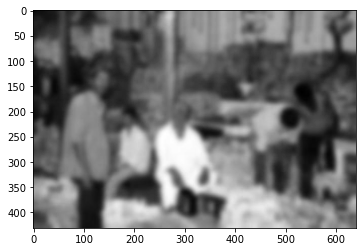

0
20
40
60
80
100
120
140
160
180


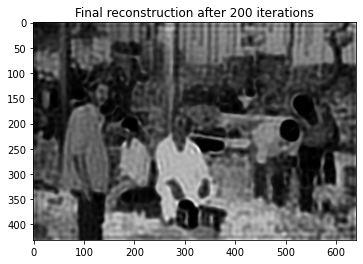

In [98]:
psf = psf_rgb[:,:,1]
data = img_rgb[:,:,1]

psf = np.array(psf, dtype='float32')
data = np.array(data, dtype='float32')

psf /= np.linalg.norm(psf.ravel(), ord=1)
# data /= np.linalg.norm(data.ravel())

plt.figure()
plt.imshow(psf, cmap='gray')
plt.show()

plt.figure()
plt.imshow(data, cmap='gray')
plt.show()

iters = 200

final_im = grad_descent(psf, data)
plt.figure()
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstruction after {} iterations'.format(iters))
plt.show()

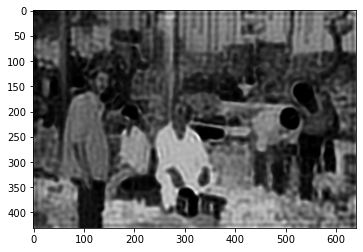

In [100]:
final_im2 = (final_im - final_im.min()) / (final_im.max() - final_im.min() + 1e-6)
plt.imshow(final_im2, cmap='gray')

0
20
40
60
80


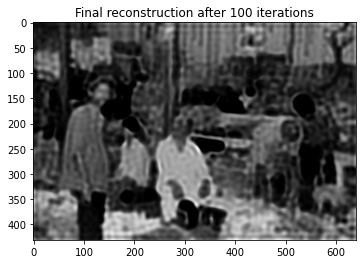

0
20
40
60
80


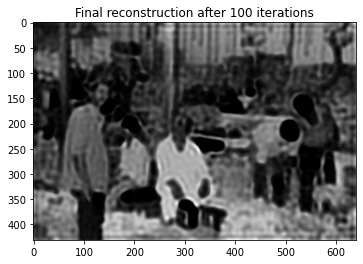

0
20
40
60
80


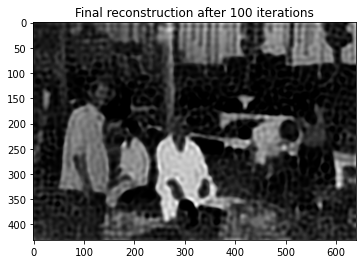

In [110]:
for i in range(3):
    
    psf = psf_rgb[:,:,i]
    data = img_rgb[:,:,i]

    psf = np.array(psf, dtype='float32')
    data = np.array(data, dtype='float32')

    psf /= np.linalg.norm(psf.ravel(), ord=1)
    # data /= np.linalg.norm(data.ravel())


    iters = 100

    final_im = grad_descent(psf, data)
    plt.figure()
    plt.imshow(final_im, cmap='gray')
    plt.title('Final reconstruction after {} iterations'.format(iters))
    plt.show()

    final_im2 = (final_im - final_im.min()) / (final_im.max() - final_im.min() + 1e-6)
    img_reconstructed[:,:,i] = final_im2 * 255


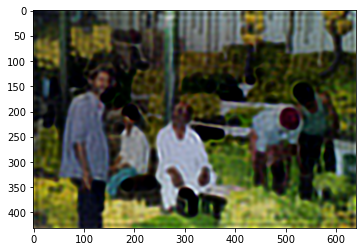

In [111]:
plt.imshow(img_reconstructed)

In [109]:
img_reconstructed

array([[[ 19,  19,  19],
        [ 19,  19,  19],
        [ 20,  20,  20],
        ...,
        [195, 195, 195],
        [195, 195, 195],
        [190, 190, 190]],

       [[ 18,  18,  18],
        [ 18,  18,  18],
        [ 19,  19,  19],
        ...,
        [198, 198, 198],
        [199, 199, 199],
        [196, 196, 196]],

       [[ 17,  17,  17],
        [ 17,  17,  17],
        [ 17,  17,  17],
        ...,
        [193, 193, 193],
        [196, 196, 196],
        [195, 195, 195]],

       ...,

       [[100, 100, 100],
        [ 98,  98,  98],
        [ 93,  93,  93],
        ...,
        [116, 116, 116],
        [126, 126, 126],
        [131, 131, 131]],

       [[104, 104, 104],
        [103, 103, 103],
        [ 99,  99,  99],
        ...,
        [128, 128, 128],
        [136, 136, 136],
        [140, 140, 140]],

       [[105, 105, 105],
        [105, 105, 105],
        [102, 102, 102],
        ...,
        [137, 137, 137],
        [143, 143, 143],
        [145, 145, 145]]

In [106]:
final_im2

array([[0.07505658, 0.07780028, 0.07912733, ..., 0.767383  , 0.7665988 ,
        0.7457019 ],
       [0.07293299, 0.07448583, 0.07472838, ..., 0.7772535 , 0.78360635,
        0.7690951 ],
       [0.06829826, 0.06837973, 0.06730558, ..., 0.75718355, 0.7717449 ,
        0.76552975],
       ...,
       [0.3957511 , 0.38713658, 0.3670668 , ..., 0.4581825 , 0.4953877 ,
        0.5166241 ],
       [0.41001353, 0.4052211 , 0.3886847 , ..., 0.50462604, 0.5363265 ,
        0.5513068 ],
       [0.41412938, 0.413325  , 0.40085676, ..., 0.5382223 , 0.5636502 ,
        0.5720863 ]], dtype=float32)

In [80]:
final_im.max()

449404.4

In [81]:
final_im.min()


0.0

In [79]:

psf = psf.resize((width//4, height//4))
data = data.resize((width//4, height//4))

psf = np.array(psf, dtype='float32')
data = np.array(data, dtype='float32')

psf /= np.linalg.norm(psf.ravel(), ord=1)
data /= np.linalg.norm(data.ravel())